In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay


# Divide the dataset into Train-test split and do the standard scalling

In [2]:
def split_transform(df,split_ratio):
    X=df.iloc[:,1:-1]
    Y=df.iloc[:,-1]
    X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=split_ratio,shuffle=True)

    scaler=StandardScaler()
    X_sc_train = scaler.fit_transform(X_train)
    X_sc_test = scaler.transform(X_test)

    print("The number of samples in the Training set is {}".format(len(X_sc_train)))
    print("The number of samples in the Test set is {}".format(len(X_sc_test)))
    
    return  X_sc_train, X_sc_test,y_train,y_test,scaler

# Import Datasets

In [3]:
df1=pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/Github/FaultDiagnosis/PanelFaultDiagnosis/PreProcessed Data/Lim_solar_data.csv')
df2=pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/Github/FaultDiagnosis/PanelFaultDiagnosis/PreProcessed Data/Max_solar_data.csv')

df = pd.concat([df1,df2],ignore_index=True,axis=0)

df.head()

,Time,Ipv,Vpv,Vdc,ia,ib,ic,va,vb,vc,Iabc,If,Vabc,Vf,label
0,0.000028,1.572327,101.348877,144.140625,-0.135133,0.490112,-0.354985,41.744537,-149.872894,109.064585,1.000000,50.000000,1.000000,50.000000,F0L
1,0.010027,1.539215,101.251221,143.261719,0.086425,-0.490112,0.349971,-42.311096,149.029083,-108.377482,1.000000,50.000000,1.000000,50.000000,F0L
2,0.020026,1.637604,101.031494,143.554688,-0.155274,0.469971,-0.307988,41.515503,-149.933167,109.104767,1.000000,50.000000,1.000000,50.000000,F0L
3,0.030025,1.577057,101.287842,142.968750,0.106566,-0.456543,0.336543,-42.106171,150.222473,-109.249420,0.461228,49.921509,151.655756,50.078264,F0L
4,0.040024,1.613007,101.049805,143.847656,-0.155274,0.456543,-0.314702,41.370850,-150.162201,109.245402,0.311221,49.594346,154.027080,50.193078,F0L


# Auto Encoder

<img src="https://pyimagesearch.com/wp-content/uploads/2020/02/keras_denoising_autoencoder_header.png"  width="700" height="400">

In [4]:
df['label'].unique()

array(['F0L', 'F1L', 'F2L', 'F3L', 'F4L', 'F5L', 'F6L', 'F7L', 'F0M',
       'F1M', 'F2M', 'F3M', 'F4M', 'F5M', 'F6M', 'F7M'], dtype=object)

In [12]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [6]:
X_sc_train, X_sc_test,y_train,y_test,scaler = split_transform(df,split_ratio=0.01)

The number of samples in the Training set is 21419
The number of samples in the Test set is 217


In [7]:
X_sc_train

array([[ 0.83536125,  0.1033749 ,  0.292519  , ...,  0.12967943,
        -0.01307672, -0.28224626],
       [ 1.3084127 , -0.16492926,  0.31396513, ...,  0.09502899,
         0.09073405,  0.05602008],
       [ 1.03116069, -0.05676751,  0.24962675, ...,  0.0662881 ,
         0.15548032, -0.06734869],
       ...,
       [-0.80152209,  0.59351566,  0.24962675, ...,  0.13266638,
         0.06613586,  0.17148488],
       [ 0.68812007,  0.11755144,  0.30324206, ...,  0.0390268 ,
        -0.04103169,  0.54501726],
       [-0.10447607,  0.57513866,  0.16384224, ...,  0.10028636,
        -0.0399484 , -0.08087733]])

In [8]:
n_inputs=X_sc_train.shape[1]
n_inputs

13

In [9]:
# define encoder
visible = Input(shape=(n_inputs,))
# encoder Level 1
e = Dense(200,activation='relu')(visible)
e = Dense(100,activation='relu')(e)
e = Dense(50,activation='relu')(e)

# bottleneck
n_bottleneck = 2
bottleneck = Dense(n_bottleneck)(e)

# define decoder, Level 1
d = Dense(50,activation='relu')(bottleneck)
d = Dense(100,activation='relu')(d)
d = Dense(200,activation='relu')(d)

# output layer
output = Dense(n_inputs, activation='linear')(d)

# define autoencoder model
model = Model(inputs=visible, outputs=output)

# compile autoencoder model
opt = Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss='mse')

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 13)]              0         
                                                                 
 dense (Dense)               (None, 200)               2800      
                                                                 
 dense_1 (Dense)             (None, 100)               20100     
                                                                 
 dense_2 (Dense)             (None, 50)                5050      
                                                                 
 dense_3 (Dense)             (None, 2)                 102       
                                                                 
 dense_4 (Dense)             (None, 50)                150       
                                                                 
 dense_5 (Dense)             (None, 100)               5100  

We use Autoencoder for encoding of features ande reducing dimentionality. then using this reduced dataset to predict with Random forest 

In [22]:
# clear the previous model (if any model is run before)
tf.keras.backend.clear_session()

# fit the autoencoder model to reconstruct input
# Note: in this model our inout and output are X_sc_train. we don't predict y_train but we predict X_sc_train.
history = model.fit(X_sc_train, X_sc_train, epochs=150, batch_size=2000, verbose=2, validation_data=(X_sc_test,X_sc_test),shuffle=True)
#After training, we can plot the learning curves for the train and test sets to confirm the model learned the reconstruction problem well.

# we use weights of Autoencoder for encoder model.
# define an encoder model (without the decoder)
encoder = Model(inputs=visible, outputs=bottleneck)

# save the encoder to file
encoder.save(r'/content/drive/MyDrive/Colab Notebooks/Github/FaultDiagnosis/PanelFaultDiagnosis/Trained_models/Encoder.h5')

Epoch 1/150
11/11 - 0s - loss: 0.0132 - val_loss: 0.0194 - 410ms/epoch - 37ms/step
Epoch 2/150
11/11 - 0s - loss: 0.0171 - val_loss: 0.0189 - 249ms/epoch - 23ms/step
Epoch 3/150
11/11 - 0s - loss: 0.0155 - val_loss: 0.0173 - 297ms/epoch - 27ms/step
Epoch 4/150
11/11 - 0s - loss: 0.0150 - val_loss: 0.0371 - 297ms/epoch - 27ms/step
Epoch 5/150
11/11 - 0s - loss: 0.0188 - val_loss: 0.0737 - 279ms/epoch - 25ms/step
Epoch 6/150
11/11 - 0s - loss: 0.0191 - val_loss: 0.0483 - 288ms/epoch - 26ms/step
Epoch 7/150
11/11 - 0s - loss: 0.0211 - val_loss: 0.0510 - 305ms/epoch - 28ms/step
Epoch 8/150
11/11 - 0s - loss: 0.0201 - val_loss: 0.0307 - 308ms/epoch - 28ms/step
Epoch 9/150
11/11 - 0s - loss: 0.0178 - val_loss: 0.0254 - 269ms/epoch - 24ms/step
Epoch 10/150
11/11 - 0s - loss: 0.0171 - val_loss: 0.0241 - 278ms/epoch - 25ms/step
Epoch 11/150
11/11 - 0s - loss: 0.0146 - val_loss: 0.0217 - 301ms/epoch - 27ms/step
Epoch 12/150
11/11 - 0s - loss: 0.0149 - val_loss: 0.0338 - 283ms/epoch - 26ms/step
E

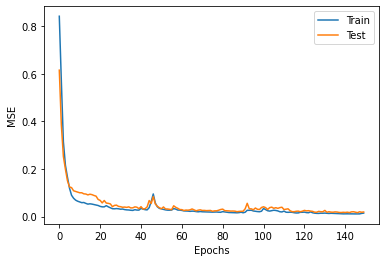

In [15]:
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend()
plt.show()

In [16]:
X_train_reconstructed = model.predict(X_sc_train)


670/670 [==============================] - 4s 5ms/step


In [17]:
X_sc_train.shape


(21419, 13)

In [18]:
X_train_reconstructed.shape

(21419, 13)

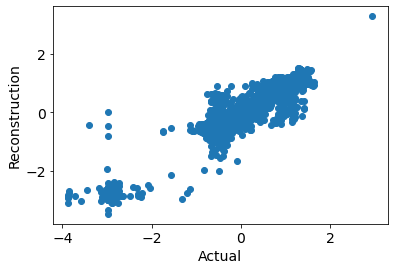

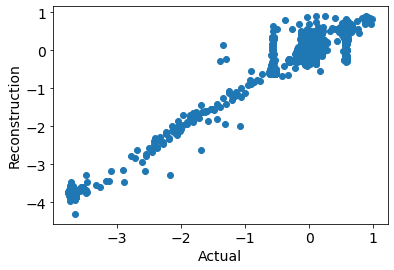

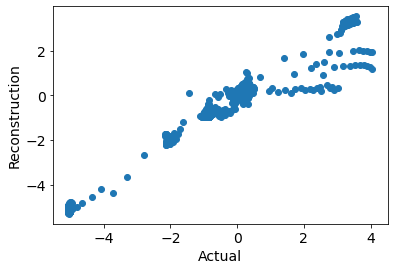

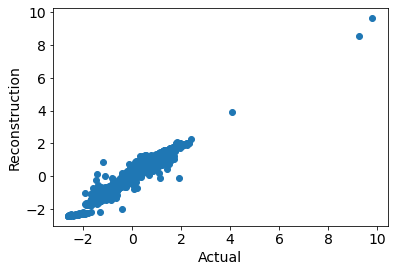

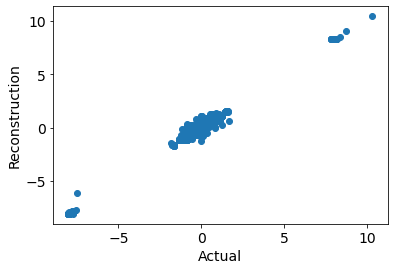

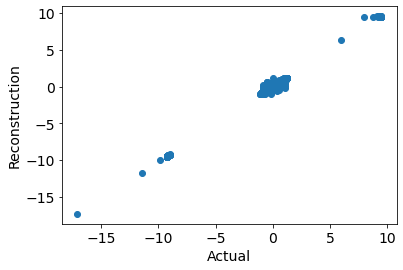

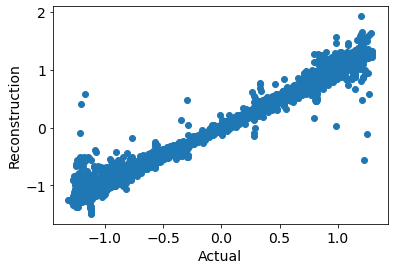

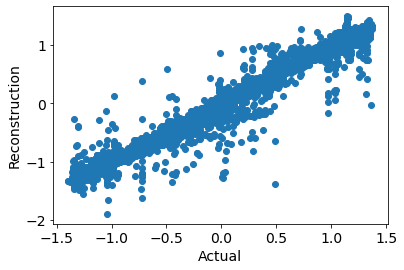

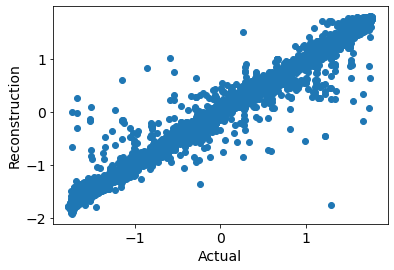

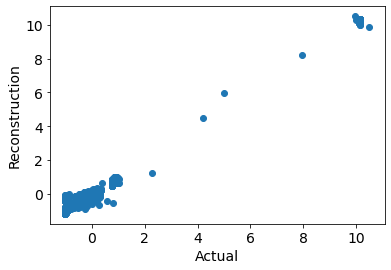

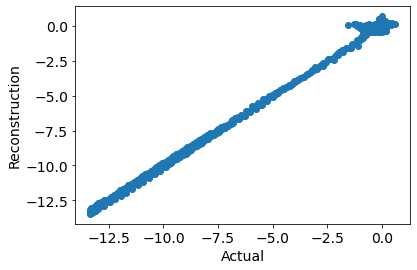

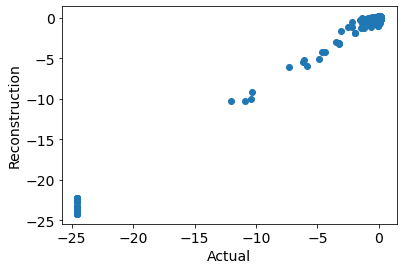

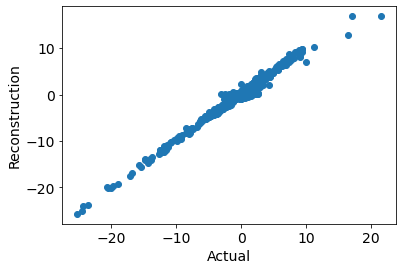

In [21]:
%matplotlib inline
plt.rcParams.update({'font.size':14})
plt.rcParams.update({"font.family" : "Times new roman"})

for i in range(X_sc_train.shape[1]):
    plt.scatter(X_sc_train[:,i],X_train_reconstructed[:,i])
    plt.xlabel("Actual")
    plt.ylabel("Reconstruction")
    plt.show()

In [23]:
# load the model from file
#encoder = load_model(r'/content/drive/MyDrive/Colab Notebooks/Github/FaultDiagnosis/PanelFaultDiagnosis/Trained_models/Encoder.h5')

# encode the train data
X_sc_train_encode = encoder.predict(X_sc_train)
# encode the test data
X_sc_test_encode = encoder.predict(X_sc_test)

7/7 [==============================] - 0s 4ms/step


In [24]:
X_sc_train_encode.shape

(21419, 2)

# Plotting the reduced dimentionality data with corresponding fault labels

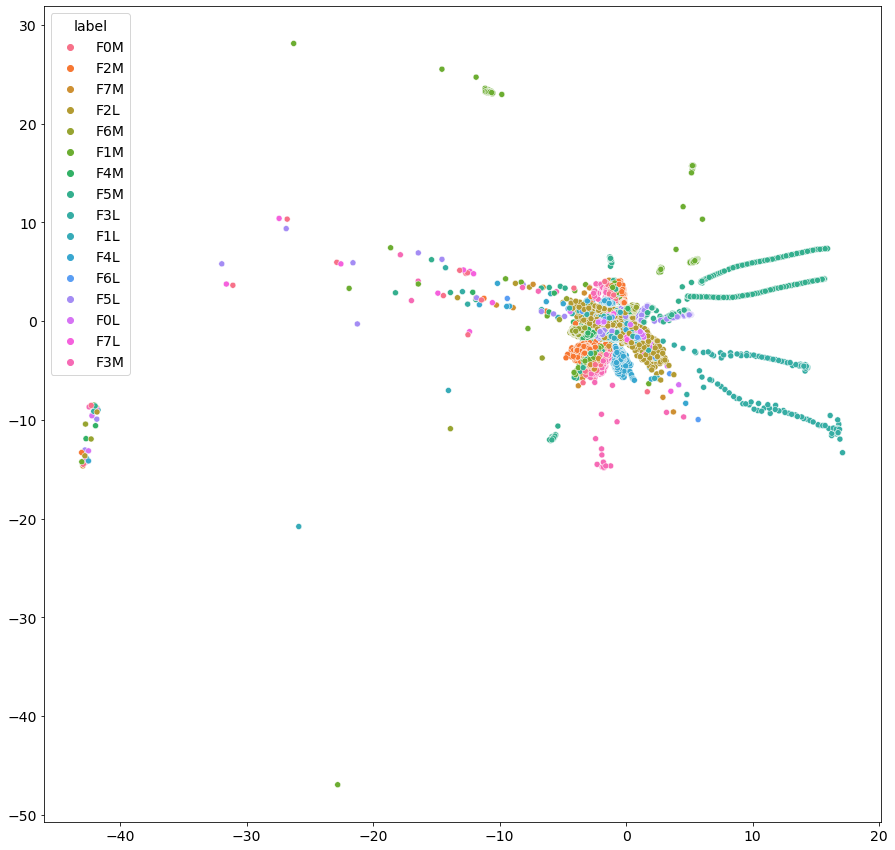

In [25]:
fig=plt.figure(figsize=(15,15))
sns.scatterplot(x=X_sc_train_encode[:,0],y=X_sc_train_encode[:,1],hue=y_train)
plt.show()

# Using The Reduced 2D data for prediction with Random Forest Classifier

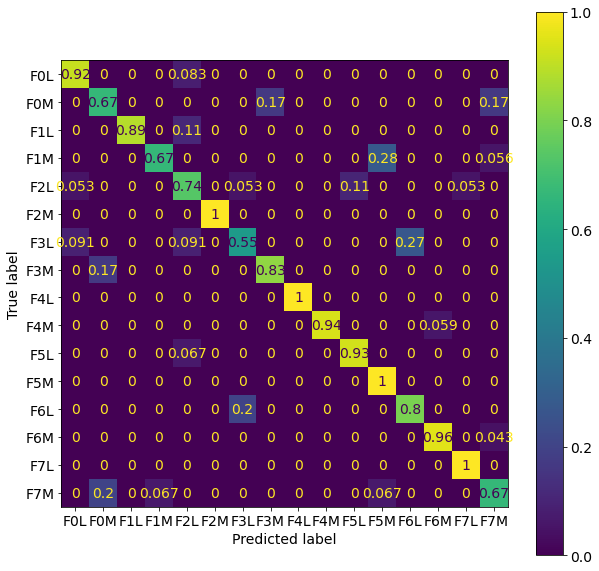

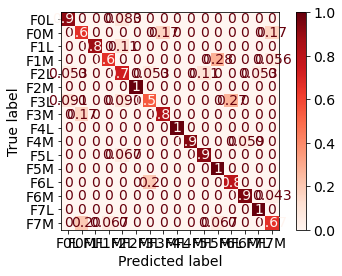

In [30]:
# X_sc_train, X_sc_test,y_train,y_test,scaler = split_transform(df,split_ratio=0.3)

Clf = RandomForestClassifier()
Clf.fit(X_sc_train_encode,y_train)

fig, ax = plt.subplots(figsize=(10,10))
disp = ConfusionMatrixDisplay.from_estimator(
    Clf,
    X_sc_test_encode,
    y_test,
    display_labels=Clf.classes_,
    cmap=plt.cm.Reds,
    normalize='true'
)


disp.plot(ax=ax)
plt.show()